## Analysis of holtankoljak.hu station and gas price data

In [3]:
import sys 
sys.path.append('../../')

from src.import_packages import *
from src.visualize_EDA import vEDA

from ast import literal_eval
import re

import stylecloud
from IPython.display import Image, display

import statsmodels.api as sm

In [54]:
data = pd.read_csv('data/scraped_data_20221211.csv')
data.head(3)

,link,address,geo_location,services,open_hours,prices
0,https://holtankoljak.net/mol_vajszlo_szechenyi...,"Vajszló, Széchenyi István út 34.","45.86290359,17.98775482","['nagynyomású kútoszlop', ' UTA-kártya', ' ban...","['Hétfő:06:00 - 20:00', '\t\t\tKedd:06:00 - 20...","{'95-ös Benzin E10': '641.0,- Ft', 'Gázolaj': ..."
1,https://holtankoljak.net/mol_jaszbereny_nagyka...,"Jászberény, Nagykátai út","47.48664474,19.88292694","['autópálya-matrica', ' kávé', ' kézi autómosó...","['Hétfő:06:00 - 22:00', '\t\t\tKedd:06:00 - 22...","{'100-As Benzin E5': '678.0,- Ft', 'Lpg': '380..."
2,https://holtankoljak.net/shell_szekszard_palan...,"Szekszárd, Palánki u. 2.","46.36576080,18.70693970","['HU-GO feltöltés', ' nagynyomású kútoszlop', ...","['Hétfő:0-24 óráig', '\t\t\tKedd:0-24 óráig', ...","{'100-As Benzin E5': '724.9,- Ft', '95-ös Benz..."


### Clean up features

In [55]:
### GEO COORDS

data[['LAT', 'LON']] = data['geo_location'].str.split(',', expand = True).astype(float)
data.drop('geo_location', 1, inplace = True)

In [56]:
### PRICES

gas_types = pd.json_normalize(data['prices'].apply(eval))
gas_types.replace({'Nem ismert' : np.nan}, inplace = True)

NaN_count = gas_types.isnull().sum() / gas_types.shape[0]
keep_cols = NaN_count[NaN_count <= .75]
print('Keeping the following gas types:', keep_cols.index.tolist())

gas_types = gas_types[keep_cols.index.tolist()]

for i in gas_types.columns:
    gas_types[i] = gas_types[i].str.replace(',- Ft', '').astype(float)

data = pd.concat([data, gas_types], 1).drop(['prices'], 1)
data['Num_of_Gas_Types'] = 5 - gas_types.isnull().sum(axis=1)

Keeping the following gas types: ['95-ös Benzin E10', 'Gázolaj', '100-As Benzin E5', 'Prémium Gázolaj', 'Gázolaj - Hatósági ÁrasÉrvényes Magyar forgalmi engedéllyel', '95-Ös Benzin E10 - Hatósági ÁrasÉrvényes Magyar forgalmi engedéllyel']


In [57]:
### OPEN HOURS

hours = data['open_hours'].apply(eval).apply(pd.Series)
hours.columns = ['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']

for i in hours.columns:

    hours[i] = hours[i]\
                    .str.replace('Hétfő:', '')\
                    .str.replace('Kedd:', '')\
                    .str.replace('Szerda:', '')\
                    .str.replace('Csütörtök:', '')\
                    .str.replace('Péntek:', '')\
                    .str.replace('Szombat:', '')\
                    .str.replace('Vasárnap:', '')\
                    .str.replace('0-24 óráig', '00:00 - 24:00')\
                    .str.replace('00:00 - 23:59', '00:00 - 24:00')\
                    .str.replace('00:00 - 00:00', '00:00 - 24:00')\
                    .str.replace('Zárva', '00:00 - 00:00')\
                    .str.replace('06:00 - 02:00', '06:00 - 26:00')\
                    .str.replace('06:00 - 00:00', '06:00 - 24:00')

def calc_hours_open(_time):
    
    OPEN = _time.split(' - ')[0]
    OPEN_CONV = int(OPEN.split(':')[0]) + int(OPEN.split(':')[1]) / 60

    CLOSE = _time.split(' - ')[1]
    CLOSE_CONV = int(CLOSE.split(':')[0]) + int(CLOSE.split(':')[1]) / 60

    HOURS_OPEN = CLOSE_CONV - OPEN_CONV

    return HOURS_OPEN

for i in hours.columns:
    hours[i] = hours[i].apply(lambda x: calc_hours_open(x))

data = pd.concat([data, hours], 1).drop(['open_hours'], 1)
data = data[data['Hétfő'] != 0]

In [58]:
data['Open_7-24'] = 0
data.loc[data[hours.columns].eq(24).all(1), 'Open_7-24'] = 1

In [59]:
### LINK

brands = pd.DataFrame(data['link'].str.replace('https://holtankoljak.net/', '').str.split('_', expand = True)[0])

brand_mapper = {'mobil' : 'mobil-petrol', 'mol-partner' : 'mol', 'oil' : 'oil!'}
brands[0].replace(brand_mapper, inplace = True)

brand_keep = brands[0].value_counts().head(10).index.tolist()
brands.loc[~brands[0].isin(brand_keep), 0] = 'magan'
brands.columns = ['brand']

data = pd.concat([data, brands], 1)

In [60]:
### BUDAPEST or NOT

data['Budapest'] = 0
data.loc[data['link'].str.contains('budap'), 'Budapest'] = 1
#data.drop('link', 1, inplace = True)

In [61]:
### AUTOPALYA or not

data['Highway'] = 0
data.loc[(data['address'].str.lower().str.contains('km')) | 
          (data['address'].str.lower().str.contains('autópálya')) | 
          (data['address'].str.lower().str.contains('m1|m2|m2|m4|m5|m6|m7')), 'Highway'] = 1
#data.drop('address', 1, inplace = True)

In [62]:
### SERVICES

data['Num_of_Services'] = data['services'].apply(eval).apply(lambda x: len(set(x)))
all_services = data['services'].apply(eval).apply(lambda x: [i.strip() for i in x if i != '']).tolist()

all_services_flat = [item for sublist in all_services for item in sublist]
all_services_set = list(set(all_services_flat))

print('Number of total unique services available:', len(all_services_set))

Number of total unique services available: 48


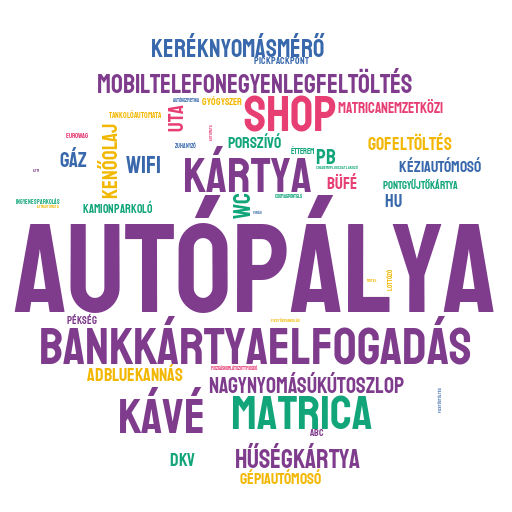

In [63]:
wc_data = ' '.join([i.replace(' ', '') for i in all_services_flat])

stylecloud.gen_stylecloud(wc_data, max_words = 750, max_font_size = 350, icon_name = 'fas fa-circle',
                          output_name = 'data/3_arstop_eltorlese/services.png', collocations = False)

display(Image(filename = 'data/3_arstop_eltorlese/services.png', width = 450))

In [67]:
drop = ['Gázolaj - Hatósági ÁrasÉrvényes Magyar forgalmi engedéllyel', '95-Ös Benzin E10 - Hatósági ÁrasÉrvényes Magyar forgalmi engedéllyel']
data.drop(drop, 1, inplace = True)

## Distributions

In [68]:
v = vEDA(data)
print(v)

EDA visualizations for given Pandas DataFrame


In [69]:
v.plot_geo_map('LAT', 'LON', zoom = 6, color_by='brand')

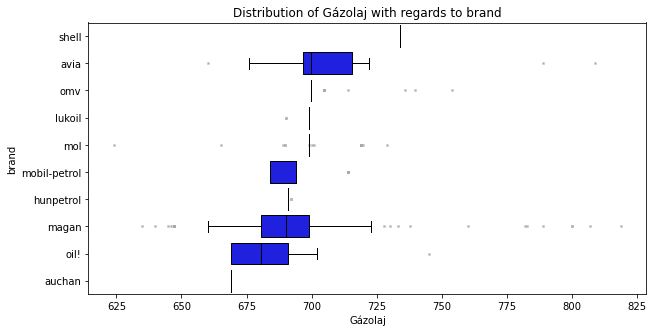

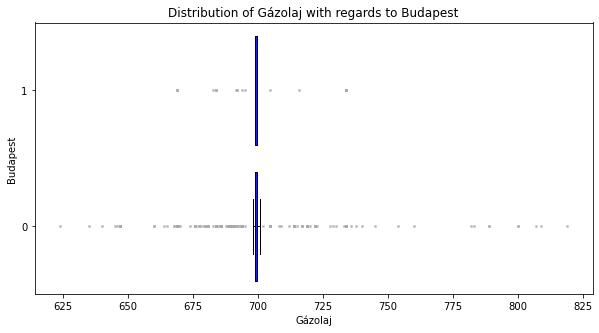

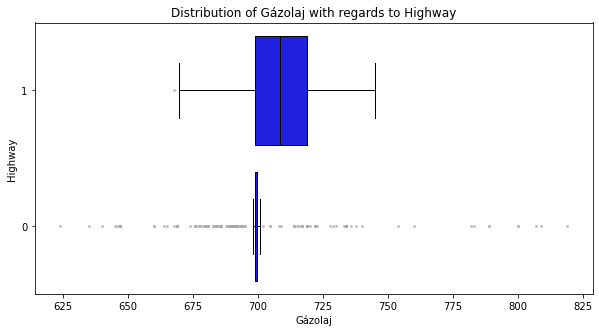

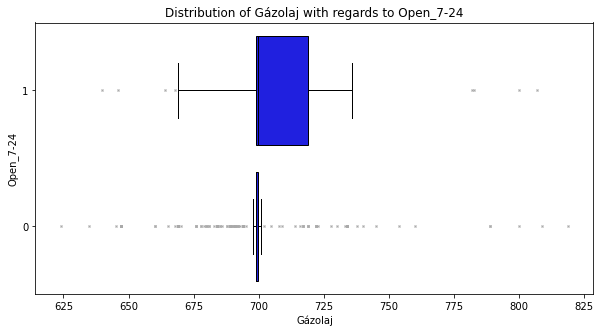

In [70]:
for i in ['brand', 'Budapest', 'Highway', 'Open_7-24']:
            v.plot_boxplot('Gázolaj', i)

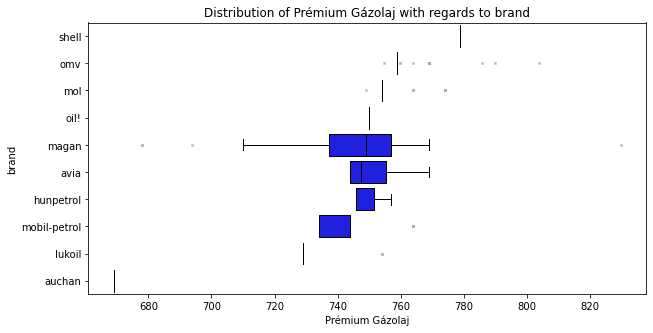

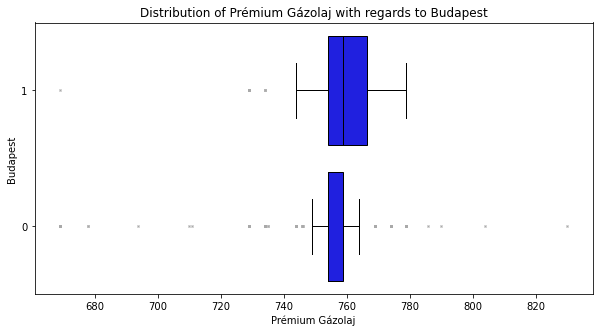

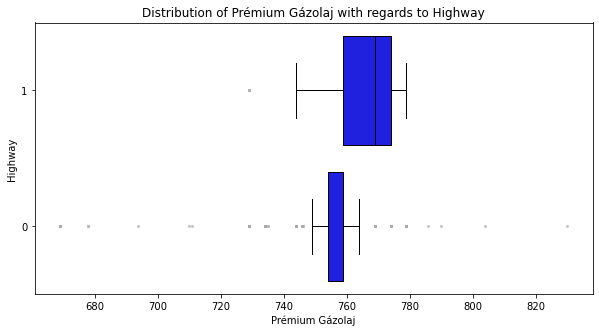

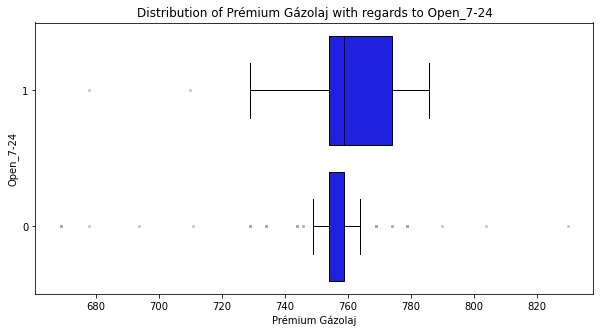

In [71]:
for i in ['brand', 'Budapest', 'Highway', 'Open_7-24']:
            v.plot_boxplot('Prémium Gázolaj', i)

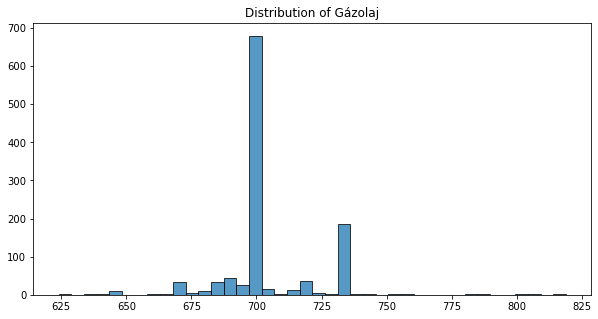

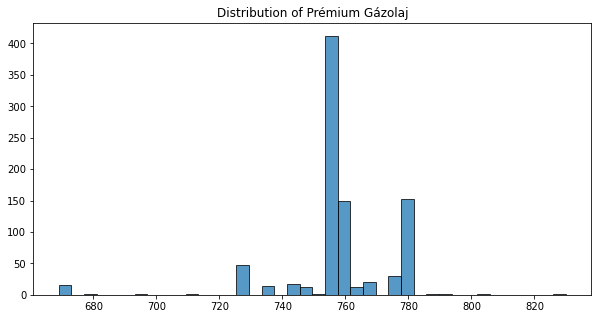

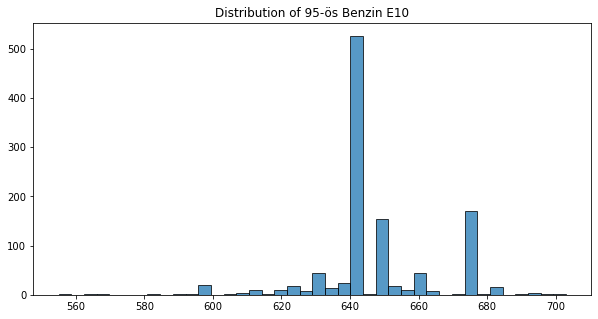

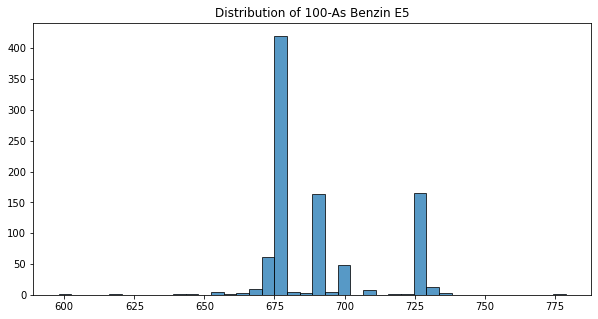

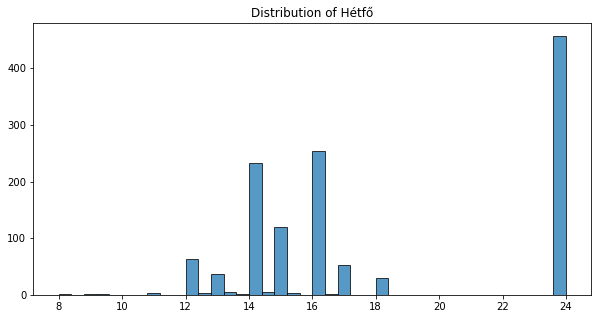

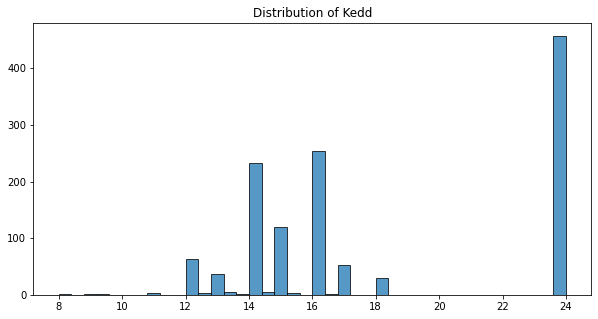

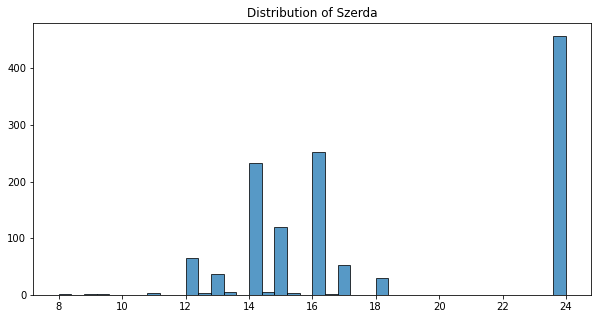

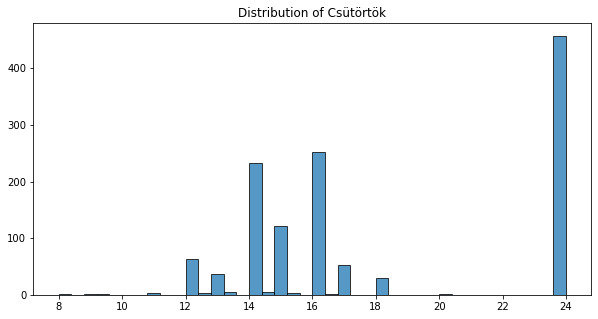

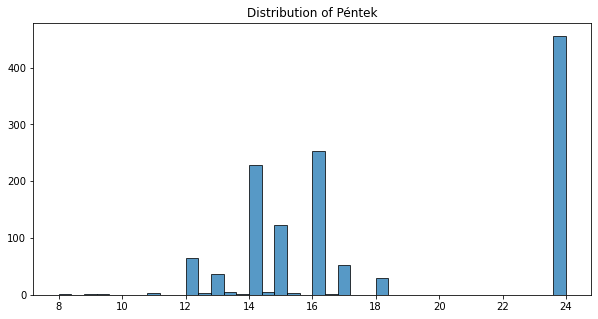

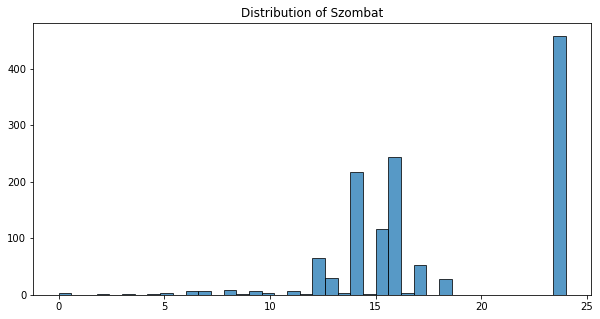

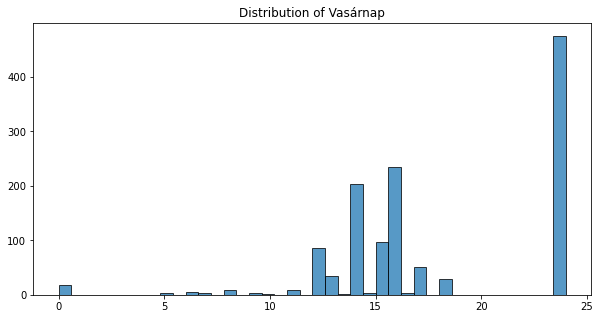

In [72]:
for i in ['Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10', '100-As Benzin E5', #'Prémium Benzin E10', 
            'Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']:
       v.plot_dist(i)

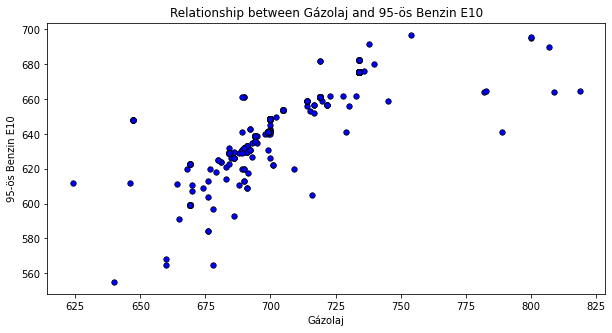

In [73]:
v.plot_scatter('Gázolaj', '95-ös Benzin E10')

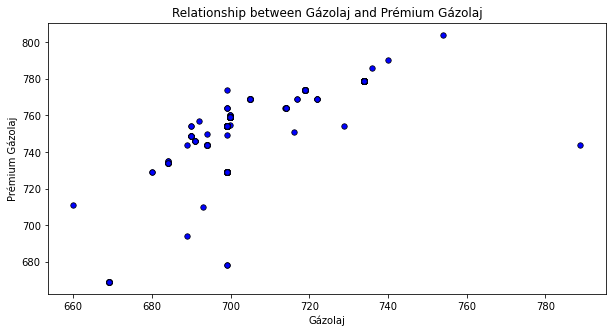

In [74]:
v.plot_scatter('Gázolaj', 'Prémium Gázolaj')

In [75]:
data[data['Gázolaj'] > 780].loc[1080]['link']

'https://holtankoljak.net/avia_martonvasar_bajcsyzsu31'

In [76]:
#data[data['Gázolaj'] > data['Prémium Gázolaj']]

In [77]:
#v.plot_scatter('95-ös Benzin E10', 'Prémium Benzin E10')

In [78]:
#v.plot_scatter('Prémium Gázolaj', 'Prémium Benzin E10')

### Correlation

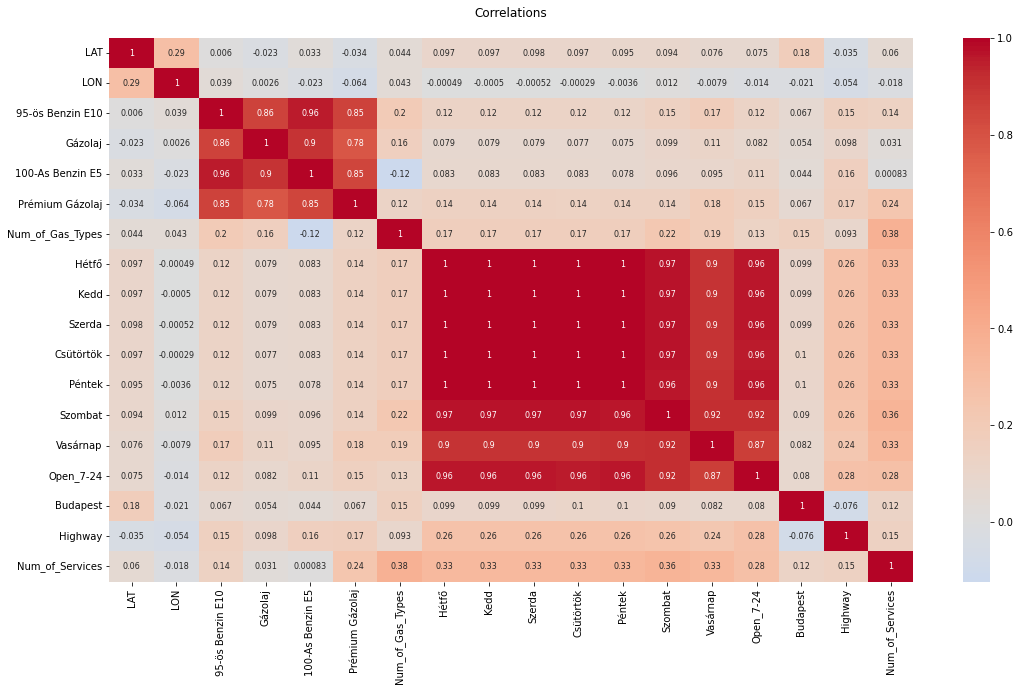

In [79]:
v.plot_corr()

### Connection between services and brands

In [80]:
crosstab_analysis = data[['brand', 'services']].copy()

pivoted = (crosstab_analysis
    .set_index('brand')
    .services.apply(eval)
    .apply(lambda x: list(set(x)))
    .apply(lambda x: [ i.strip() for i in x if i != ''])
    .apply(lambda x: ','.join(x))
    .str.split(',', expand = True)
    .stack()
    .reset_index()
    .pivot_table(index = 'brand', columns = 0, fill_value = 0, aggfunc = 'size')
)

drop_services = pivoted.sum()[pivoted.sum().sort_values() <= 50].index.tolist()

pivoted = (crosstab_analysis
    .set_index('brand')
    .services.apply(eval)
    .apply(lambda x: list(set(x)))
    .apply(lambda x: [ i.strip() for i in x if i != ''])
    .apply(lambda x: [ i for i in x if i not in drop_services])
    .apply(lambda x: ','.join(x))
    .str.split(',', expand = True)
    .stack()
    .reset_index()
    .pivot_table(index = 'brand', columns = 0, fill_value = 0, aggfunc = 'size')
)


In [81]:
pivoted

,,ABC,AdBlue kannás,DKV-kártya,Eurowag-kártya,Gyógyszer,HU-GO feltöltés,Lottózó,PB-gáz,Pick Pack Pont,...,kávé,kézi autómosó,mobiltelefon egyenlegfeltöltés,nagynyomású kútoszlop,pontgyűjtő kártya,porszívó,pékség,shop,tankoló automata,Étterem
brand,,,,,,,,,,,,,,,,,,,,,
auchan,0,0,0,15,0,0,0,0,17,0,...,0,0,2,11,0,4,0,0,18,0
avia,0,5,14,6,12,3,12,3,35,1,...,32,14,35,15,4,16,4,34,2,0
hunpetrol,0,0,1,0,0,0,2,1,0,0,...,1,1,8,0,0,1,0,1,9,0
lukoil,0,23,10,76,0,0,23,0,2,0,...,78,11,57,0,0,12,21,79,2,0
magan,8,7,55,26,24,0,48,9,114,1,...,145,50,110,70,0,50,6,152,24,10
mobil-petrol,0,1,0,0,3,0,26,1,19,0,...,44,29,32,12,0,21,0,42,9,1
mol,0,9,136,95,2,132,129,51,318,121,...,415,153,441,345,5,47,127,462,8,12
oil!,0,0,6,11,14,0,12,2,32,0,...,44,12,40,18,0,12,0,46,4,5
omv,0,75,9,166,4,0,75,0,41,5,...,172,59,29,123,141,135,1,178,2,35


## Modeling (Premium) Diesel prices with simple OLS

### Baseline model without services, other fuel types, geo data

In [91]:
Y = 'Prémium Gázolaj'
p_signif = 0.01

In [92]:
abt = data.copy()

if Y == 'Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'services', 'LAT', 'LON',
            'Prémium Gázolaj', '95-ös Benzin E10', '100-As Benzin E5'], 1, inplace = True) #'Prémium Benzin E10'
    abt = abt[abt['Gázolaj'].notnull()]

if Y == 'Prémium Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'services', 'LAT', 'LON',
            'Gázolaj', '95-ös Benzin E10', '100-As Benzin E5'], 1, inplace = True) #'Prémium Benzin E10', 
    abt = abt[abt['Prémium Gázolaj'].notnull()]


abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [93]:
X = abt_dummified.drop([Y], 1)
X = sm.add_constant(X)
y = abt_dummified[Y]

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= p_signif]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [94]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Prémium Gázolaj   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     756.7
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:54:59   Log-Likelihood:                -2972.0
No. Observations:                 893   AIC:                             5960.
Df Residuals:                     885   BIC:                             5998.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             740.8376      1.370    540.772      0.000     738.149     743.526
Highway             9.3567      0.790     11.838      0.000       7.805      10.908
Num_of_Services     0.2251      0.080      2.821      0.005       0.068       0.382
brand = auchan    -73.7737      1.972    -37.405      0.000     -77.645     -69.903
brand = lukoil    -14.4281      1.283    -11.244      0.000     -16.947     -11.910
brand = mol        10.6940      0.863     12.391      0.000       9.000      12.388
brand = omv        14.4764      1.000     14.477      0.000      12.514      16.439
brand = shell      34.2274      0.971     35.234      0.000      32.321      36.134
==============================================================================
Omnibus:                      360.237   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119772.767
Skew:                           0.458   Prob(JB):                         0.00
Kurtosis:                      59.729   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adding all services as dummies

In [95]:
abt = data.copy()

if Y == 'Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'LAT', 'LON',
            'Prémium Gázolaj', '95-ös Benzin E10',  '100-As Benzin E5'], 1, inplace = True) #'Prémium Benzin E10',
    abt = abt[abt['Gázolaj'].notnull()]

if Y == 'Prémium Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'LAT', 'LON',
            'Gázolaj', '95-ös Benzin E10', '100-As Benzin E5'], 1, inplace = True) #'Prémium Benzin E10',
    abt = abt[abt['Prémium Gázolaj'].notnull()]

abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [96]:
services_dummified = abt_dummified.services.apply(eval).apply(lambda x: list(set(x))).apply(lambda x: [ i.strip() for i in x if i != '']).apply(lambda x: [ i for i in x if i not in drop_services]).str.join('|').str.get_dummies()

#services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM automata'] = services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM-automata']
#services_dummified.drop(['ATM-automata'], 1, inplace = True)

In [97]:
abt_dummified = pd.concat([abt_dummified, services_dummified], 1).drop('services', 1)

In [98]:
X = abt_dummified.drop([Y], 1)
X = sm.add_constant(X)
y = abt_dummified[Y]

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= p_signif]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [99]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Prémium Gázolaj   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     765.6
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:55:23   Log-Likelihood:                -2967.5
No. Observations:                 893   AIC:                             5951.
Df Residuals:                     885   BIC:                             5989.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            742.6422      0.864    859.879      0.000     740.947     744.337
Highway            9.4327      0.781     12.070      0.000       7.899      10.967
brand = auchan   -77.1113      1.987    -38.811      0.000     -81.011     -73.212
brand = lukoil   -16.6038      1.329    -12.491      0.000     -19.213     -13.995
brand = mol        8.8054      0.973      9.048      0.000       6.895      10.715
brand = omv       13.2928      1.069     12.433      0.000      11.194      15.391
brand = shell     32.1874      1.073     30.002      0.000      30.082      34.293
hűségkártya        3.4691      0.842      4.121      0.000       1.817       5.121
==============================================================================
Omnibus:                      410.125   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124481.247
Skew:                           0.806   Prob(JB):                         0.00
Kurtosis:                      60.818   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion: 
- adding service indicators increased adj R2 from 91.4 to 92.5
- most influence: **BRAND**, **number of services**, **couple of services (flowers, motel, free charging, paid parking)**